## GWAS and eQTL Colocalizations Across MPRA Variants

In [1]:
library(tidyverse)
library(data.table)
library(fs)
library(bedr)
library(ggpubr)
library(ggrepel)
library(patchwork)
library(ggridges)
library(parallel)
library(pbapply)

setwd("~/work/mpra-v2")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




######################
#### bedr v1.0.7 ####
######################

checking binary availability...
  * Checking path for bedtools... FAIL
  * Checking path for bedops... FAIL
  * Checking path for tabix... PASS
    /scg/apps/software/jupyter/python_3.7/bin/tabix
tests and examples will be skipped on R CMD check if binaries are missing




In [2]:
mpraStats = fread("sumstats/1KG_novaSeq_DESeq2_Love_Base.txt", header = T, stringsAsFactors = F)

mpraStats.tmp = mpraStats[,c(3,4,5,6,7,8,9,23,27,29,30,33)]
mpraStats.tmp = subset(mpraStats.tmp, haploFlag == "Base" & !is.na(geneID))
mpraStats.tmp = separate_rows(mpraStats.tmp, geneID,sep = ",")

In [3]:
haploVarsExpr = fread("sumstats/haplotype/Expression.txt")
haploVars = fread("sumstats/haplotype/Allele3.txt")

haploVars$log2FoldChange_expr = haploVarsExpr$log2FoldChange
haploVars$padj_expr = haploVarsExpr$padj

haploVarsFormat = haploVars %>% 
                    filter(Pool == "1KGTest") %>%
                    select(chrom,pos.x,pos.y,geneID,strand,ref.x,alt.x,haploFlag.x,
                           log2FoldChange_expr,padj_expr,log2FoldChange,lfcSE,padj)

pos1 = haploVarsFormat[,-2]
pos2 = haploVarsFormat[,-3]

names(pos1) = c("chrom","pos","geneID","strand","ref","alt","haploFlag","log2FoldChange_expr","padj_expr","log2FoldChange_allele","lfcSE_allele","padj_allele")
names(pos2) = c("chrom","pos","geneID","strand","ref","alt","haploFlag","log2FoldChange_expr","padj_expr","log2FoldChange_allele","lfcSE_allele","padj_allele")

haploVarsFormat = rbind(pos1,pos2)
mpraStats.tmp = rbind(mpraStats.tmp,haploVarsFormat)

In [5]:
hgTable = fread("annotation/hgConversionTable.txt", stringsAsFactors = F, header = T)
mpraStats.tmp = merge(mpraStats.tmp, unique(hgTable),
                      by.x = c("chrom","pos"),
                      by.y = c("hg19_chrom","hg19_pos"))
eqtl.sub = fread("zcat annotation/Cells_EBV-transformed_lymphocytes.allpairs.subset.bed.gz")

In [6]:
files = dir_ls("/oak/stanford/groups/smontgom/shared/GTEx/barbeira_coloc/results_enloc_priors/Cells_EBV-transformed_lymphocytes/",glob="*txt.gz",recurse = T)
names(files) = str_split_fixed(names(files),pattern = "/",n=11)[,11]
files = paste0("zcat ",files)
data = suppressWarnings(files %>% map_dfr(fread, .id = "source"))
data$gene_id = gsub("\\..*","",data$gene_id, perl=T)

Taking input= as a system command ('zcat /oak/stanford/groups/smontgom/shared/GTEx/barbeira_coloc/results_enloc_priors/Cells_EBV-transformed_lymphocytes/ADIPOGen_Adiponectin__PM__Cells_EBV-transformed_lymphocytes.txt.gz') and a variable has been used in the expression passed to `input=`. Please use fread(cmd=...). There is a security concern if you are creating an app, and the app could have a malicious user, and the app is not running in a secure environment; e.g. the app is running as root. Please read item 5 in the NEWS file for v1.11.6 for more information and for the option to suppress this message.

Taking input= as a system command ('zcat /oak/stanford/groups/smontgom/shared/GTEx/barbeira_coloc/results_enloc_priors/Cells_EBV-transformed_lymphocytes/Astle_et_al_2016_Eosinophil_counts__PM__Cells_EBV-transformed_lymphocytes.txt.gz') and a variable has been used in the expression passed to `input=`. Please use fread(cmd=...). There is a security concern if you are creating an app, a

In [14]:
hitCounts = mpraStats.tmp %>% 
                filter(!is.na(geneID) & geneID != "") %>% 
                mutate(hit = ifelse(padj_allele < 5e-2 & padj_expr < 5e-2,"hit","nonhit")) %>%
                group_by(geneID, hit) %>% 
                summarize(count=n())

hitCounts = merge(hitCounts, data,
                  by.x="geneID",by.y = "gene_id")

posteriors = hitCounts %>% 
                group_by(geneID,source,p0,p1,p2,p3,p4) %>% 
                spread(hit,count,fill=0)

posteriors$file = apply(posteriors,1,function(x) files[as.integer(x[2])])
posteriors$file = gsub("zcat /oak/stanford/groups/smontgom/shared/GTEx/barbeira_coloc/results_enloc_priors/Cells_EBV-transformed_lymphocytes/","",posteriors$file)
posteriors$file = gsub("__PM__Cells_EBV-transformed_lymphocytes.txt.gz","",posteriors$file)

hitsOnly = subset(posteriors, (hit+nonhit>=10) & (hit > 0) & (p3 + p4 > 0.5))

`summarise()` regrouping output by 'geneID' (override with `.groups` argument)



In [18]:
write.table(hitsOnly, "sumstats/gtex-gwas-coloc-searchList.txt", quote = F, sep = "\t", col.names = T, row.names = F)

In [142]:
annotateSumStats = function(colocVector, mpraStats.tmp = mpraStats.tmp, eqtl.sub = eqtl.sub){

    gene = colocVector[1]
    trait = colocVector[10]
    
    gwas = paste0("gwas/imputed_",trait,".subset.txt.gz")

    testVars = subset(mpraStats.tmp, geneID == gene)
    sigVars = subset(mpraStats.tmp, geneID == gene & padj_allele < 5e-2 & padj_expr < 5e-2)
    
    e1 = subset(eqtl.sub, V6 == gene)

    minPos = as.character(min(e1$V2))
    maxPos = as.character(max(e1$V3))
    chrom = unique(e1$V1)
    query = paste0(chrom,":",minPos,"-",maxPos)

    g1 = tryCatch( tabix(region = query,file.name = gwas,check.chr = T) ,
                  error = function(e) {return(data.frame("V2" = 1, "V9" = 1))} )
    g1$V9 = as.numeric(g1$V9)
    
    testedEQTL = subset(e1, V2 %in% testVars$hg38_pos)
    testedGWAS = subset(g1, V2 %in% testVars$hg38_pos)
    
    sigEQTL = subset(e1, V2 %in% sigVars$hg38_pos)
    sigGWAS = subset(g1, V2 %in% sigVars$hg38_pos)

    maxSigEQTL = ifelse(nrow(sigEQTL) > 0,max(-log10(sigEQTL$V8), na.rm = T),0)
    maxSigGWAS = ifelse(nrow(sigGWAS) > 0,max(-log10(sigGWAS$V9), na.rm = T),0)
    
    maxNonSigEQTL = ifelse(nrow(testedEQTL) > 0, max(-log10(testedEQTL$V8), na.rm = T),0)
    maxNonSigGWAS = ifelse(nrow(testedGWAS) > 0, max(-log10(testedGWAS$V9), na.rm = T),0)
    
    return(c(maxSigEQTL,maxSigGWAS,maxNonSigEQTL,maxNonSigGWAS))
}

In [143]:
results = data.frame("maxSigEQTL" = NULL,"maxSigGWAS" = NULL,"maxNonSigEQTL" = NULL,"maxNonSigGWAS" = NULL)

for(i in 1:nrow(hitsOnly)){
        
    p = annotateSumStats(c(hitsOnly[i,]), mpraStats.tmp = mpraStats.tmp, eqtl.sub = eqtl.sub)
    
    results = rbind(results,p)
    
}

In [44]:
cl = makeCluster(15)
maxSumStats = parApply(cl,hitsOnly,1,annotateSumStats,mpraStats.tmp = mpraStats.tmp, eqtl.sub = eqtl.sub)
stopCluster(cl)

maxSumStats = as.data.frame(t(maxSumStats))
names(maxSumStats) = c("maxSigEQTL","maxSigGWAS","maxNonSigEQTL","maxNonSigGWAS")

hitsOnlyWithSumStats = cbind(as.data.frame(hitsOnly), maxSumStats)

write.table(hitsOnlyWithSumStats, "sumstats/gtex-gwas-colocs.txt", col.names = T ,row.names = F, sep = "\t", quote = F)

In [20]:
hitsOnlyWithSumStats = fread("sumstats/gtex-gwas-colocs.txt")
ensg2gene = read.delim("annotation/ensg2gene.txt", header = F, stringsAsFactors = F) %>% 
                separate(V1,c("ensg","gene"),sep = "_",extra = "merge")

hitsOnlyWithSumStats = merge(hitsOnlyWithSumStats, ensg2gene, by.x = "geneID",by.y="ensg")
hitsOnlyWithSumStats[which(hitsOnlyWithSumStats$geneID == "ENSG00000164308"),"gene"] = "ERAP2" 
hitsOnlyWithSumStats[which(hitsOnlyWithSumStats$gene == "C8orf40"),"gene"] = "SMIM19"
hitsOnlyWithSumStats[which(hitsOnlyWithSumStats$gene == "C8orf70"),"gene"] = "ZC2HC1A"
hitsOnlyWithSumStats[which(hitsOnlyWithSumStats$gene == "C12orf48"),"gene"] = "PARBP"

In [21]:
hitsFilt = hitsOnlyWithSumStats %>% 
                filter(maxSigEQTL > -log10(5e-5) & maxSigGWAS > -log10(5e-8)) %>% 
                group_by(file,gene,hit) %>% 
                summarize(count=n())

gwasLabels = data.frame("file" = unique(hitsFilt$file),
                       "trait" = c("Eosinophil Count",
                                   "Granuloctye Count",
                                   "HLS Reticulocyte Count",
                                   "Lymphocyte Count",
                                   "Monocyte Count",
                                   "Myeloid White Cell Count",
                                   "Neutrophil Count",
                                   "Platelet Count",
                                   "Red Blood Cell Count",
                                   "Reticulocyte Count",
                                   "Basophil+Neutrophil Count",
                                   "Basophil+Eosinophil Count",
                                   "Neutrophil+Eosinophil Count",
                                   "White Blood Cell Count",
                                   "Chronic Kidney Disease",
                                   "Pubertal Growth",
                                   "Height (GIANT)",
                                   "Crohns Disease",
                                   "Inflammatory Bowel Disease",
                                   "Multiple Sclerosis",
                                   "Systemic Lupus Erythematosus",
                                   "Hyperthyroidism/Thyrotoxicosis, Self-Reported (UKB)",
                                   "Hypothyroidism/Myxoedema, Self-Reported (UKB)",
                                   "Fluid Intelligence Score (UKB)",
                                   "Birth Weight (UKB)",
                                   "Body Mass Index (UKB)",
                                   "Body Fat Percentage (UKB)",
                                   "Height (UKB)",
                                   "Allergic Rhinitis/Eczema, Diagnosed (UKB)"))

hitsFilt = merge(hitsFilt, gwasLabels, by="file")

`summarise()` regrouping output by 'file', 'gene' (override with `.groups` argument)



In [24]:
write.table(hitsFilt,"sumstats/gtex-gwas-colocs-summary.txt", col.names = T, row.names= F, quote = F, sep = "\t")

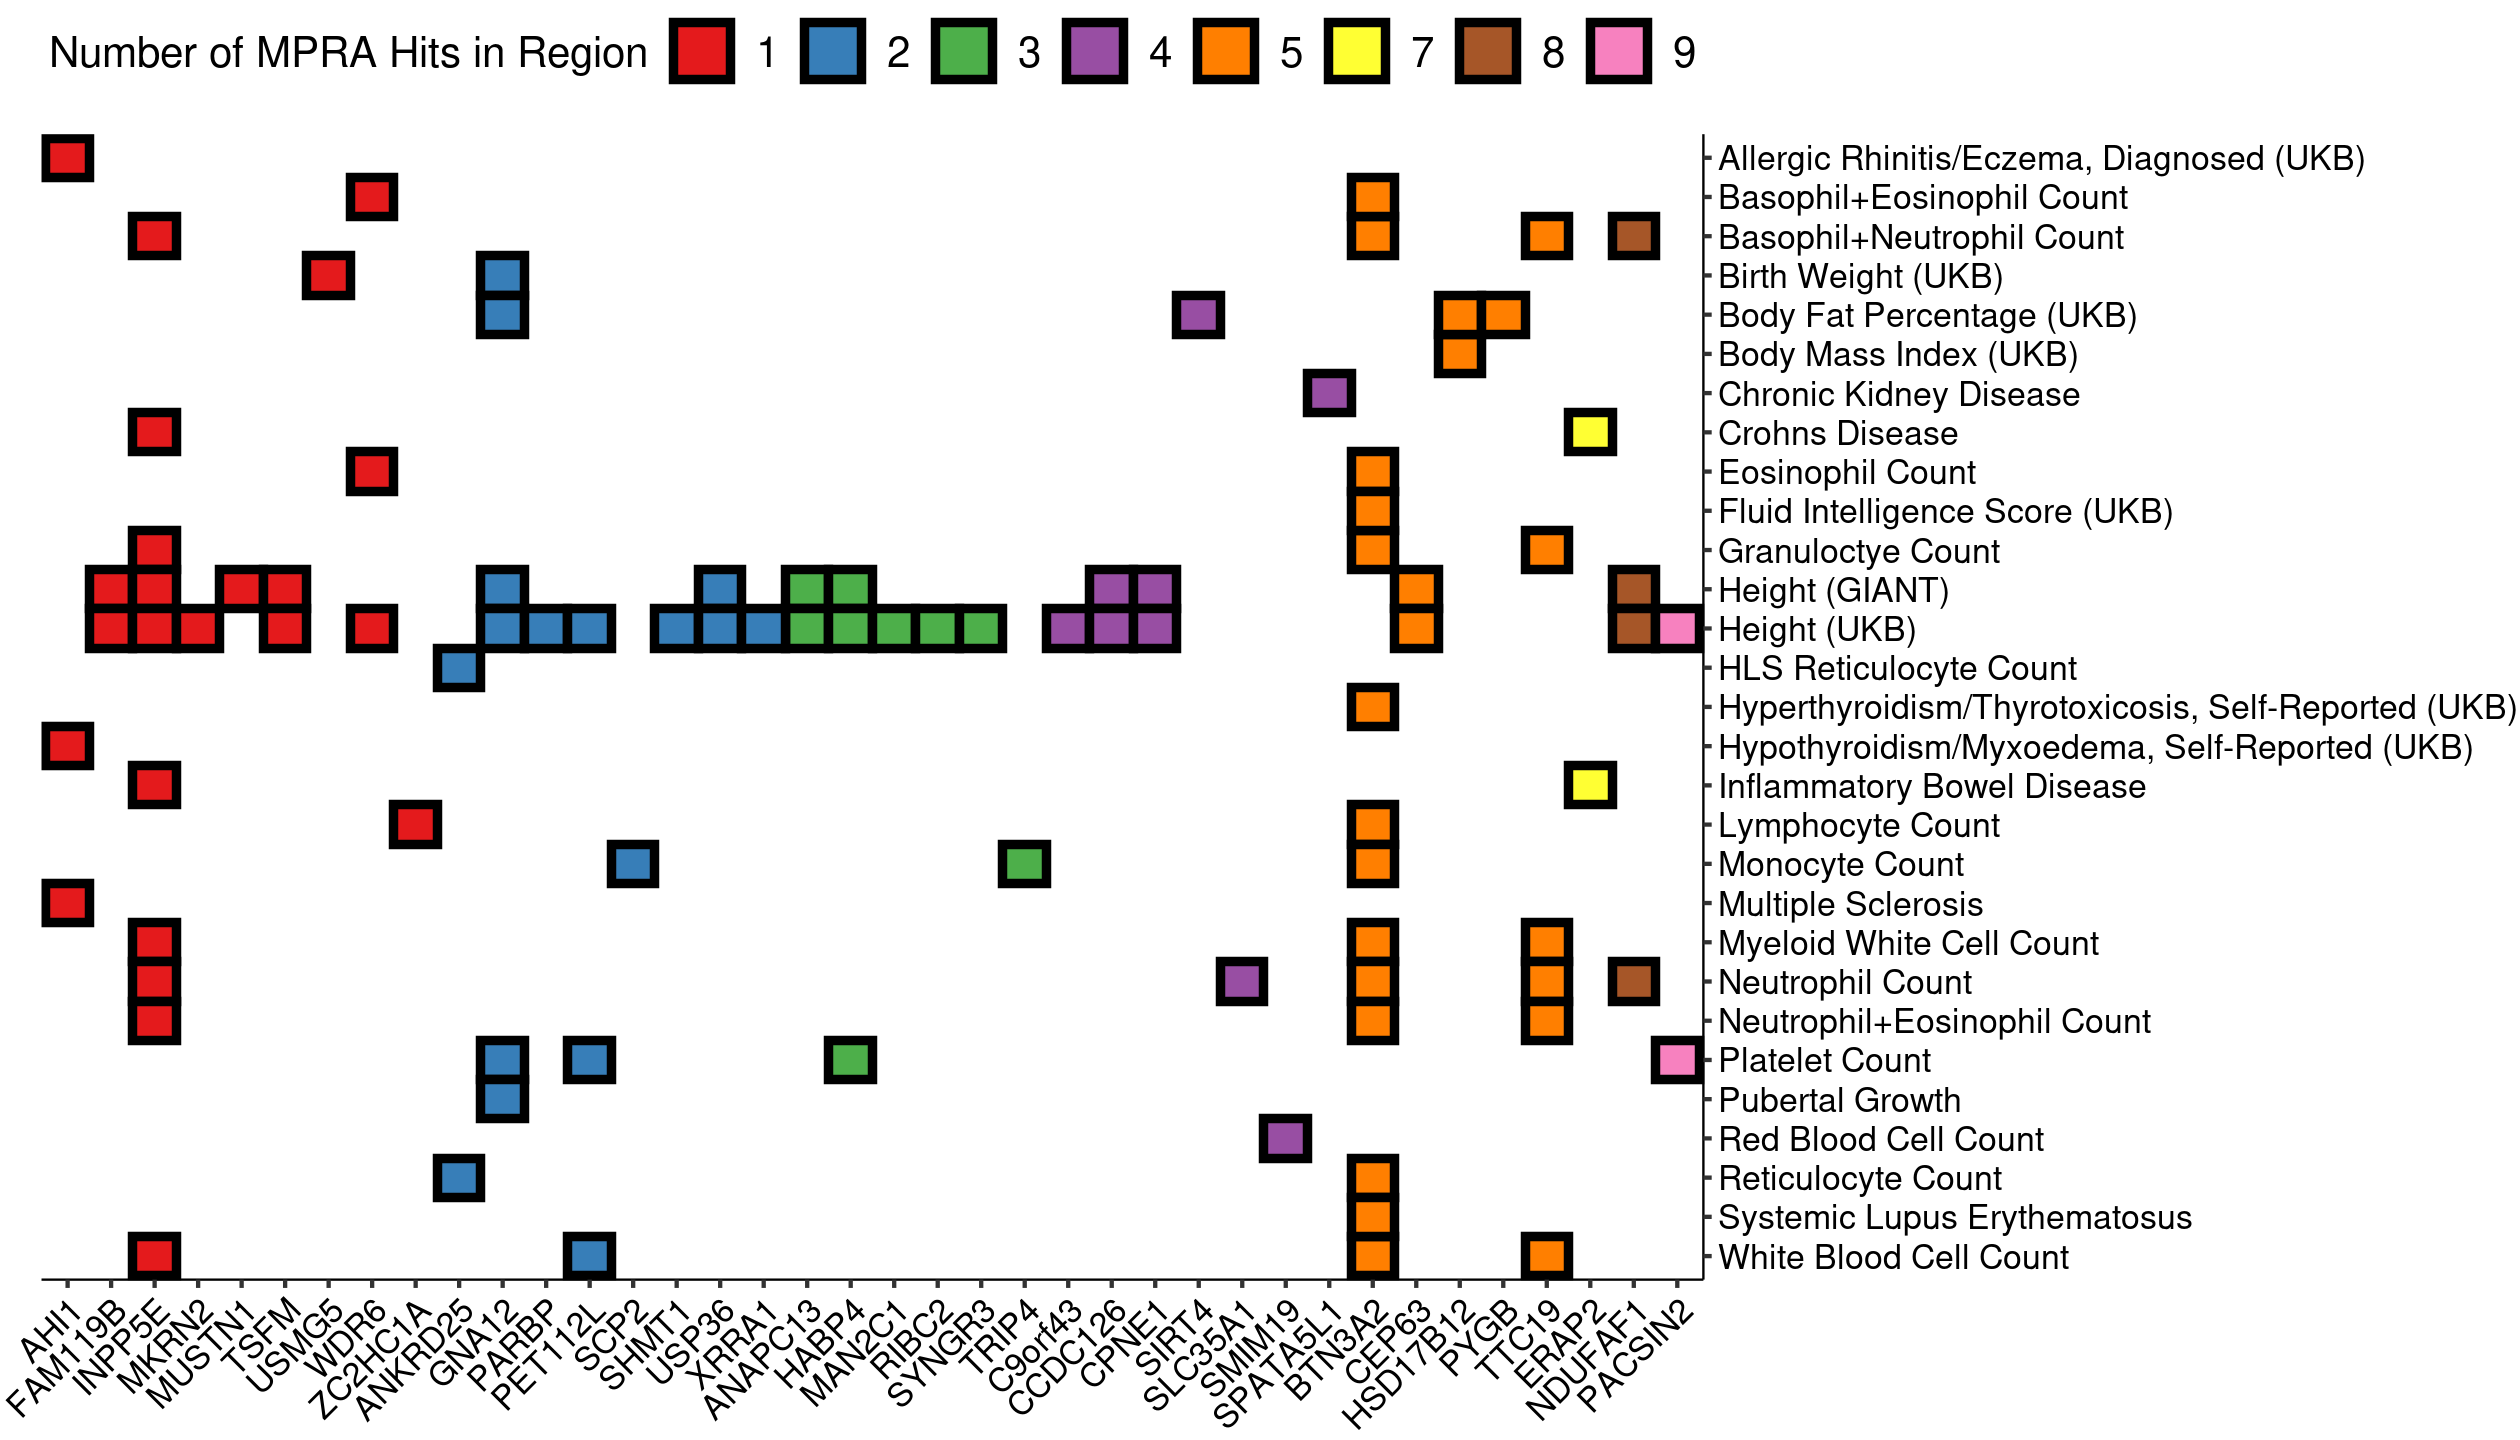

In [25]:
options(repr.plot.width=21,repr.plot.height=12)
gwasHeatmap = ggplot(hitsFilt) + 
    geom_tile(aes(y = factor(trait, levels = rev(levels(factor(trait)))),
                  x = reorder(gene,hit), 
                  fill = as.factor(hit)),color = "black",size=2) +
    theme_pubr(base_size = 20,x.text.angle = 45) +
    scale_fill_brewer(name="Number of MPRA Hits in Region", palette = "Set1") + 
    theme(axis.title = element_blank(),
          legend.title=element_text(size=25),
          legend.text=element_text(size=25),
          legend.key.size = unit(1.4, "cm"),
          plot.margin = margin(t = 1, r = 1, b = 1, l = 25, unit = "pt")) + 
    scale_y_discrete(position = "right") +
    guides(fill=guide_legend(nrow=1,byrow=TRUE)) 

gwasHeatmap

In [26]:
colocsToPlot = hitsOnlyWithSumStats %>% 
                    filter(maxSigEQTL > -log10(5e-5) & maxSigGWAS > -log10(5e-8)) %>% 
                    group_by(file,geneID,gene,hit) %>% 
                    summarize(count=n())

`summarise()` regrouping output by 'file', 'geneID', 'gene' (override with `.groups` argument)



In [28]:
plotColoc = function(gene,gwas,geneName,gwasName){
    
    gwas = paste0("gwas/imputed_",gwas,".subset.txt.gz")
    testVars = subset(mpraStats.tmp, geneID == gene)
    sigVars = subset(mpraStats.tmp, geneID == gene & padj_allele < 5e-2 & padj_expr < 5e-2)

    e1 = subset(eqtl.sub, V6 == gene)

    minPos = as.character(min(e1$V2))
    maxPos = as.character(max(e1$V3))
    chrom = unique(e1$V1)
    query = paste0(chrom,":",minPos,"-",maxPos)

    g1 = tabix(region = query,file.name = gwas,check.chr = T)

    eqtlPlot = ggplot(e1) + 
                    geom_point(aes(x = as.numeric(V2), y = -log10(V8)),color = "black") + 
                    geom_point(data = subset(e1, V2 %in% testVars$hg38_pos), 
                               aes(x = as.numeric(V2), y = -log10(V8)), color = "dodgerblue", size = 3) + 
                    geom_point(data = subset(e1, V2 %in% sigVars$hg38_pos),
                               aes(x = as.numeric(V2), y = -log10(V8)),
                               color = "red", fill = "red", size = 5, shape = 23) + 
                    theme_pubr(base_size = 14) + #geom_vline(xintercept = 135418217) + geom_vline(xintercept = 135512325) +
                    ylab(paste0(geneName," -logP")) + xlab("hg38 position") #+ xlim(c(42300000,42700000))

    gwasPlot = ggplot(g1) + 
                    geom_point(aes(x = as.numeric(V2), y = -log10(as.numeric(V9))),color = "black") + 
                    geom_point(data = subset(g1, V2 %in% testVars$hg38_pos), 
                               aes(x = as.numeric(V2), y = -log10(as.numeric(V9))), color = "dodgerblue", size = 3) + 
                    geom_point(data = subset(g1, V2 %in% sigVars$hg38_pos),
                               aes(x = as.numeric(V2), y = -log10(as.numeric(V9))),
                               color = "red", fill = "red", size = 5, shape = 23) + 
                    theme_pubr(base_size = 14)  + #geom_vline(xintercept = 135418217) + geom_vline(xintercept = 135512325) +
                    ylab(paste0(gwasName," -logP")) + xlab("hg38 position") #+ geom_hline(yintercept = -log10(5e-8))

    m = merge(g1,e1,by=c("V1","V2"))

    comparePlot = ggplot(data = m, 
                         aes(x = -log10(as.numeric(V9.x)),y = -log10(as.numeric(V8.y)))) + 
                        geom_point() +
                        geom_point(data = subset(m, V2 %in% testVars$hg38_pos),
                                   aes(x = -log10(as.numeric(V9.x)), 
                                       y = -log10(as.numeric(V8.y))), 
                                   color = "dodgerblue", size = 3) +
                        geom_point(data = subset(m, V2 %in% sigVars$hg38_pos),
                                   aes(x = -log10(as.numeric(V9.x)), 
                                       y = -log10(as.numeric(V8.y))), 
                                   color = "red", fill = "red", size = 5, shape = 23) + 
                        theme_pubr(base_size = 14) +
                        xlab("GWAS -logP") + ylab("eQTL -logP")
    
    finalPlot = eqtlPlot|gwasPlot|comparePlot
    return(finalPlot)
}

pdf("MPRA-GTEx-coloc-all.pdf",width = 15, height = 5, useDingbats = F)
for(i in 1:nrow(finalColocs)){
    
    theRow = finalColocs[i,]
    print(theRow[2])
    thePlot = plotColoc(as.character(theRow[2]),theRow[1],theRow[3],theRow[1])
    print(thePlot)
}
dev.off()

# A tibble: 1 x 1
# Groups:   geneID [1]
  geneID         
  <chr>          
1 ENSG00000178252
TABIX-QUERY
 * Processing input (1): 
CONVERT TO BED
 * Checking input type... PASS
   Input is in index format
VALIDATE REGIONS
 * Check if index is a string... PASS
 * Check index pattern... PASS
 * Check for missing values... PASS
 * Check for larger start position... PASS.
 * Check if zero based... PASS
 * Checking sort order... PASS
 * Checking for overlapping 'contiguous' regions... FAIL
   The input for object has overlapping features!
   This can cause unexpected results for some set operations.
   i.e. x <- bedr.merge.region(x)

bash -c 'tabix  gwas/imputed_Astle_et_al_2016_Eosinophil_counts.subset.txt.gz -R /tmp/Rtmp080sLd/_a61325a00444.bed '
# A tibble: 1 x 1
# Groups:   geneID [1]
  geneID         
  <chr>          
1 ENSG00000186470
TABIX-QUERY
 * Processing input (1): 
CONVERT TO BED
 * Checking input type... PASS
   Input is in index format
VALIDATE REGIONS
 * Check if index is

png 
  2

In [29]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/libopenblas-r0.3.3.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] pbapply_1.4-3     ggridges_0.5.2    patchwork_1.1.0   ggrepel_0.8.2    
 [5] ggpubr_0.4.0      bedr_1.0.7        fs_1.5.0          data.table_1.13.2
 [9] forcats_0.5.0     stringr_1.4.0     dplyr_1.0.2       purrr_0.3.4      
[13] readr_1.4.0       tidyr_1.1.2       tibble_3.0.4      ggplot2_3.3.2    
[17] tidyvers